# Theoretical Neuroscience: Project 1

**Professor:** Brian Frost-Laplante

**Spring 2025**

---

This notebook implements spike‐train generation using concepts from Chapter 1 of _Dayan and Abbott’s Theoretical Neuroscience_ {cite}`dayanTheoreticalNeuroscienceComputational2001`.

I consider homogeneous and inhomogeneous poisson processes with and without refractoriness as models of stochastic spike sequences. To characterize the stochastic properties of spiking I compute the Fano factor, interspike interval (ISI) probability distributions, coefficient of variation (CV), and spike‐train autocorrelation function.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import Union, Dict, Any

### Helper Functions

In [2]:
def spike_train2spike_times(spike_train: np.ndarray, dt: float):
    return np.where(spike_train)[0] * dt # np.where returns a tuple where the first element is an array of the indices of the True values in the input array
original_spike_train = np.array([0, 1, 0, 1, 0])
spike_train2spike_times(original_spike_train, dt=0.001)
print(f"spike train: {original_spike_train} -> spike times: {spike_train2spike_times(original_spike_train, dt=0.001)}")

spike train: [0 1 0 1 0] -> spike times: [0.001 0.003]


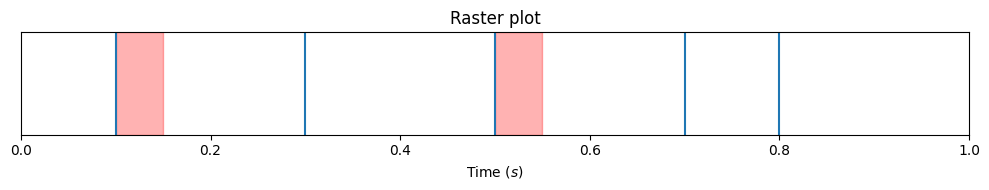

In [3]:
def raster_plot(ax:plt.Axes, spike_times:np.ndarray, highlight_ref: bool=True, refractory_periods: list=[], xlim=(0, 1), title="Raster plot"):
    # Plot vertical lines for each spike.
    ax.vlines(spike_times, 0, 1)
    
    # Overlay the refractory periods if highlight_ref is True.
    if highlight_ref and any(refractory_periods):
        for start, end in refractory_periods:
            ax.axvspan(start, end, color='red', alpha=0.3)
        
    ax.set_ylim(0, 1)
    ax.set_xlim(xlim)
    ax.get_yaxis().set_visible(False)
    ax.set_title(title)

fig, ax = plt.subplots(1, 1, figsize=(10, 2))
raster_plot(ax, [0.1, 0.3, 0.5, 0.7, 0.8], refractory_periods=[(0.1, 0.15), (0.5, 0.55)], title="Raster plot")
ax.set_xlabel("Time ($s$)")
plt.tight_layout()
plt.show()


## Spike Train Generation

**Poisson Process**

The poisson distribution is given by

$$
P_T[n] = \frac{(rT)^n}{n!} \exp(-rT).
$$

where $P_T[n]$ is the probability of observing $n$ spikes in time $T$ given a firing rate of $r$. For a homogeneous poisson process, the firing rate is constant; for an inhomogeneous poisson process, the firing rate is time-varying.

**Refractory Period**

> "For a few milliseconds just after an action potential has been fired, it may be virtually impossible to initiate another spike. This is called the absolute refractory period." ({cite}`dayanTheoreticalNeuroscienceComputational2001`, p.21)

> "Refractory effects can be incorporated into a Poisson model of spike generation by setting the firing rate to 0 immediately after a spike is fired, and then letting it return to its predicted value according to some dynamic rule such as an exponential recovery." ({cite}`dayanTheoreticalNeuroscienceComputational2001`, p.48)

> "Both the length of the absolute and relative refractory period depend on the nerve cell under consideration, but typical values in the central nervous system are 0.5–1 ms and ≈ 10 ms, respectively." {cite}`gabbianiMathematicsNeuroscientists2010`

The rule I implemented is an absolute refractory period of 1 ms summed with a relative refractory period drawn from an exponential distribution with a mean of 10 ms.


In [4]:
# Initialize random number generator
rng = np.random.default_rng()

### Trial Parameters and Time Varying Firing Rate

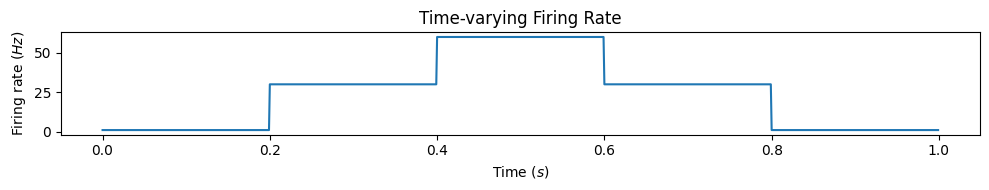

In [5]:
# Define parameters
T = 1 
dt = 0.001
abs_ref = 0.001
rel_ref_mean = 0.01
r = 60

# Time varying firing rate
r_t = np.repeat([1, 30, 60, 30, 1], round((T/dt)/5))
fig, ax = plt.subplots(1, 1, figsize=(10, 2))
ax.plot(np.arange(0, T, dt), r_t)
ax.set_xlabel("Time ($s$)")
ax.set_ylabel("Firing rate ($Hz$)")
ax.set_title("Time-varying Firing Rate")
plt.tight_layout()
plt.show()

### Simple Spike Generator

For the spike generation I initially used the following procedure:

> "Spike sequences can be simulated by using some estimate of the firing rate, $r_{\text{est}}(t)$, predicted from knowledge of the stimulus, to drive a Poisson process. A simple procedure for generating spikes in a computer program is based on the fact that the estimated probability of firing a spike during a short interval of duration $\Delta t$ is $r_{\text{est}}(t) \Delta t$. The program progresses through time in small steps of size $\Delta t$ and generates, at each time step, a random number $x*{\text{rand}}$ chosen uniformly in the range between 0 and 1. If $r_{\text{est}}(t) \Delta t > x\_{\text{rand}}$ at that time step, a spike is fired; otherwise it is not." ({cite}`dayanTheoreticalNeuroscienceComputational2001`, p.47)

In [6]:
def simple_spike_generator(
    r: Union[float, np.ndarray],
    T: float = 1,
    dt: float = 0.001,
    refractory: bool = False,
    abs_ref: float = 0.001,
    rel_ref_mean: float = 0.01,
) -> np.ndarray:
    """Generate a spike train array according to a Poisson process.

    Args:
        r (Union[float, np.ndarray]): Constant firing rate if scalar or time varying array of firing rates at each time step (Hz).
        T (float, optional): Trial duration (s). Defaults to 1.
        dt (float, optional): Time step size (s). Defaults to 0.001.
        refractory (bool, optional): Whether to include refractory periods. Defaults to False.
        abs_ref (float, optional): Absolute refractory period (s). Defaults to 0.001.
        rel_ref_mean (float, optional): Mean relative refractory period (s). Defaults to 0.01.

    Returns:
        np.ndarray: spike train array; when a spike is present, the value is 1, otherwise 0.
    """
    spike_train_length = round(T / dt)
    spike_train = np.zeros(spike_train_length)
    next_possible_index = 0  # index until which the neuron is refractory

    # Use a homogeneous poisson process if r is scalar, inhomogeneous otherwise (r should be an array of the same length as spike_train)
    homogeneous = np.isscalar(r)         
    
    for i in range(spike_train_length):
        if i < next_possible_index:
            continue

        firing_rate = r if homogeneous else r[i]
        if rng.random() < firing_rate * dt:
            spike_train[i] = 1
            if refractory:
                ref_period = abs_ref + rng.exponential(scale=rel_ref_mean)
                ref_time_steps = np.ceil(ref_period / dt)
                next_possible_index = i + ref_time_steps

    return spike_train
simple_spike_generator(60)[:10]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

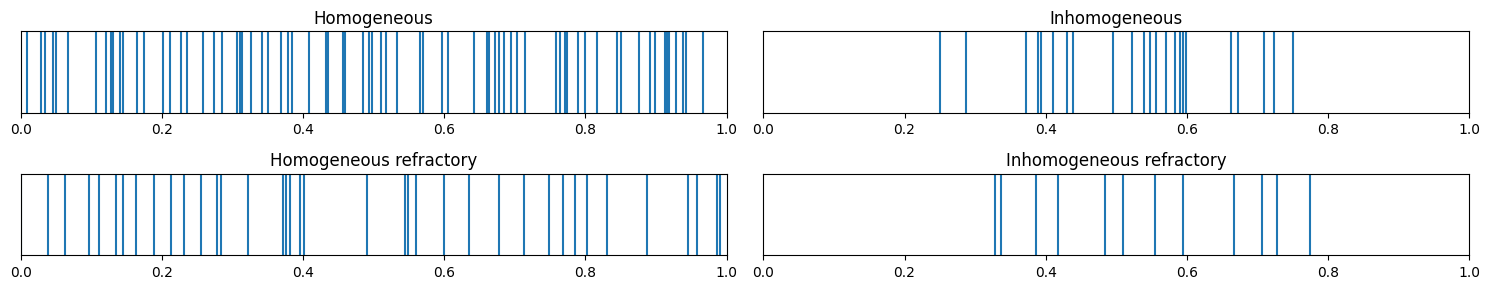

In [7]:
# Generate spike trains
simple_spike_train_homogeneous = simple_spike_generator(r, T=T, dt=dt, abs_ref=abs_ref, refractory=False, rel_ref_mean=rel_ref_mean)
simple_spike_train_inhomogeneous = simple_spike_generator(r_t, T=T, dt=dt, abs_ref=abs_ref, refractory=False, rel_ref_mean=rel_ref_mean)
simple_spike_train_homogeneous_refractory = simple_spike_generator(r, T=T, dt=dt, abs_ref=abs_ref, refractory=True, rel_ref_mean=rel_ref_mean)
simple_spike_train_inhomogeneous_refractory = simple_spike_generator(r_t, T=T, dt=dt, abs_ref=abs_ref, refractory=True, rel_ref_mean=rel_ref_mean)

# Plot spike trains
fig, axes = plt.subplots(2, 2, figsize=(15, 3))
raster_plot(axes[0, 0], spike_train2spike_times(simple_spike_train_homogeneous, dt=dt), title="Homogeneous")
raster_plot(axes[0, 1], spike_train2spike_times(simple_spike_train_inhomogeneous, dt=dt), title="Inhomogeneous")
raster_plot(axes[1, 0], spike_train2spike_times(simple_spike_train_homogeneous_refractory, dt=dt), title="Homogeneous refractory")
raster_plot(axes[1, 1], spike_train2spike_times(simple_spike_train_inhomogeneous_refractory, dt=dt), title="Inhomogeneous refractory")
fig.tight_layout()

### Interspike Interval Spike Generators

**Faster homogeneous spike generator**
> For a constant firing rate, it is faster to compute spike times $t_i$ for $i = 1, 2, ... n$ iteratively by generating interspike intervals from an exponential probability density ({cite}`dayanTheoreticalNeuroscienceComputational2001`, p.47)

**Faster inhomogeneous spike generator**
> Rejection sampling or spike thinning. The thinning technique requires a bound $r_{\text{max}}$ on the estimated firing rate such that $r_{\text{est}}(t) \leq r_{\text{max}}$ at all times. We first generate a spike sequence corresponding to the constant rate $r_{\text{max}}$ by iterating the rule $t_{i+1} = t_i - \ln(x_{\text{rand}}) / r_{\text{max}}$. The spikes are then thinned by generating another $x_{\text{rand}}$ for each $i$ and removing the spike at time $t_i$ from the train if $r_{\text{est}}(t_i) / r_{\text{max}} < x_{\text{rand}}$. If $r_{\text{est}}(t_i) / r_{\text{max}} \geq x_{\text{rand}}$, spike $i$ is retained. Thinning corrects for the difference between the estimated time-dependent rate and the maximum rate. ({cite}`dayanTheoreticalNeuroscienceComputational2001`, p.47)

**Refractory Period**

The refractory period is implemented using a similar spike thinning process, where spikes are removed if they occur within the refractory period of the previous spike.

**Comparison of Spike Generators**

| Attribute | Simple Generator | Fast Generator |
| --- | --- | --- |
| Precision | Limited by bin size | Up to 17 decimal points {cite}`pythonFloatingPointArithmeticIssues2025`|
| Length of Spike Train | Fixed | Arbitrary (Can be cutoff to fixed length) |
| Number of Spikes | Arbitrary | Fixed (Becomes arbitrary after cutoff) |


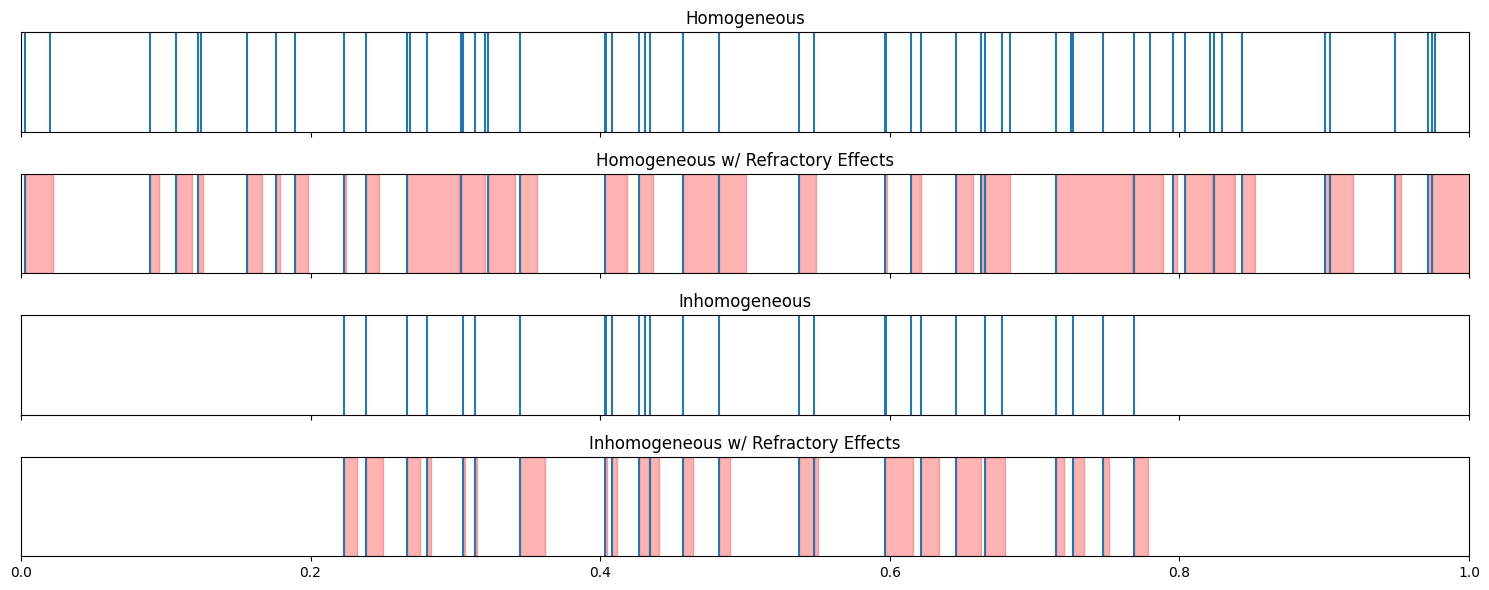

In [8]:
def fast_spike_generator(
    r: Union[float, np.ndarray],
    T: float = 1,
    dt: float = 0.001,
    abs_ref: float = 0.001,
    rel_ref_mean: float = 0.01,
    return_refractory_periods: bool = False,
) -> Dict[str, Dict[str, Any]]:
    """Generate a dictionary of spike trains driven by a Poisson process.

    Args:
        r (Union[float, np.ndarray]): Constant firing rate if scalar or time varying array of firing rates at each time step (Hz).
        T (float, optional): Trial duration (s). Defaults to 1.
        dt (float, optional): Time step size of `r_t` (s). Defaults to 0.001.
        abs_ref (float, optional): Absolute refractory period (s). Defaults to 0.001.
        rel_ref_mean (float, optional): Mean relative refractory period (s). Defaults to 0.01.
        return_refractory_periods (bool, optional): Flag to return refractory periods in dict. Defaults to False.
    Returns:
        (Dict[str, Any]): {"Spike Times Poisson": np.ndarray, "Spike Times Refractory": np.ndarray, "Refractory Periods": list}
    """
    # Use a homogeneous poisson process if r is scalar, inhomogeneous otherwise (r should be an array of the same length as spike_train)
    homogeneous = np.isscalar(r)         
    if homogeneous:
        max_firing_rate = r
    else:
        max_firing_rate = max(r)
    interspike_intervals = rng.exponential(scale=1/max_firing_rate, size=round(max_firing_rate * T * 2))
    spike_times = np.cumsum(interspike_intervals)
    spike_times = spike_times[spike_times < T] # Cutoff at extra spikes at T
    spike_times_homogeneous = spike_times.copy()
    
    # Spike thinning for inhomogeneous Poisson process
    if not homogeneous:
        spike_indices_to_remove = []
        for i, spike_time in enumerate(spike_times):
            firing_rate_index = round(spike_time / dt) - 1 # index of the spike time in the time varying firing rate array, -1 to account for 0 indexing
            if r_t[firing_rate_index] / max_firing_rate < rng.random():
                spike_indices_to_remove.append(i)
        spike_times = np.delete(spike_times, spike_indices_to_remove)
    spike_times_inhomogeneous = spike_times.copy()
        
    for spike_times in [spike_times_homogeneous, spike_times_inhomogeneous]:
        valid_spike_times = []
        refractory_periods = []
        i = 0
        while i < len(spike_times):
            current_time = spike_times[i]
            valid_spike_times.append(current_time)

            # The refractory period for this spike.
            ref_period = abs_ref + rng.exponential(scale=rel_ref_mean)
            refractory_periods.append((current_time, current_time + ref_period))

            # Skip any spikes within this refractory period
            i += 1
            while i < len(spike_times) and spike_times[i] < current_time + ref_period:
                i += 1
                
        if spike_times is spike_times_homogeneous:
            spike_times_homogeneous_refractory = np.array(valid_spike_times)
            refractory_periods_homogeneous = refractory_periods
        else:
            spike_times_inhomogeneous_refractory = np.array(valid_spike_times)
            refractory_periods_inhomogeneous = refractory_periods
    
    spikes_dict = {
        "Homogeneous Spike Times": spike_times_homogeneous,
        "Homogeneous Spike Times w/ Refractory Effects": spike_times_homogeneous_refractory,
        "Inhomogeneous Spike Times": spike_times_inhomogeneous,
        "Inhomogeneous Spike Times w/ Refractory Effects": spike_times_inhomogeneous_refractory
    }
    
    if return_refractory_periods:
        spikes_dict.update({
            "Homogeneous Refractory Periods": refractory_periods_homogeneous,
            "Inhomogeneous Refractory Periods": refractory_periods_inhomogeneous
        })
    
    return spikes_dict

spikes_dict = fast_spike_generator(r_t, T=T, dt=dt, abs_ref=abs_ref, rel_ref_mean=rel_ref_mean, return_refractory_periods=True)

# Plot spike trains
fig, axes = plt.subplots(4, 1, figsize=(15, 6), sharex=True)
raster_plot(axes[0], spikes_dict["Homogeneous Spike Times"], title="Homogeneous")
raster_plot(axes[1], spikes_dict["Homogeneous Spike Times w/ Refractory Effects"], refractory_periods=spikes_dict["Homogeneous Refractory Periods"], title="Homogeneous w/ Refractory Effects")
raster_plot(axes[2], spikes_dict["Inhomogeneous Spike Times"], title="Inhomogeneous")
raster_plot(axes[3], spikes_dict["Inhomogeneous Spike Times w/ Refractory Effects"], refractory_periods=spikes_dict["Inhomogeneous Refractory Periods"], title="Inhomogeneous w/ Refractory Effects")
fig.tight_layout()

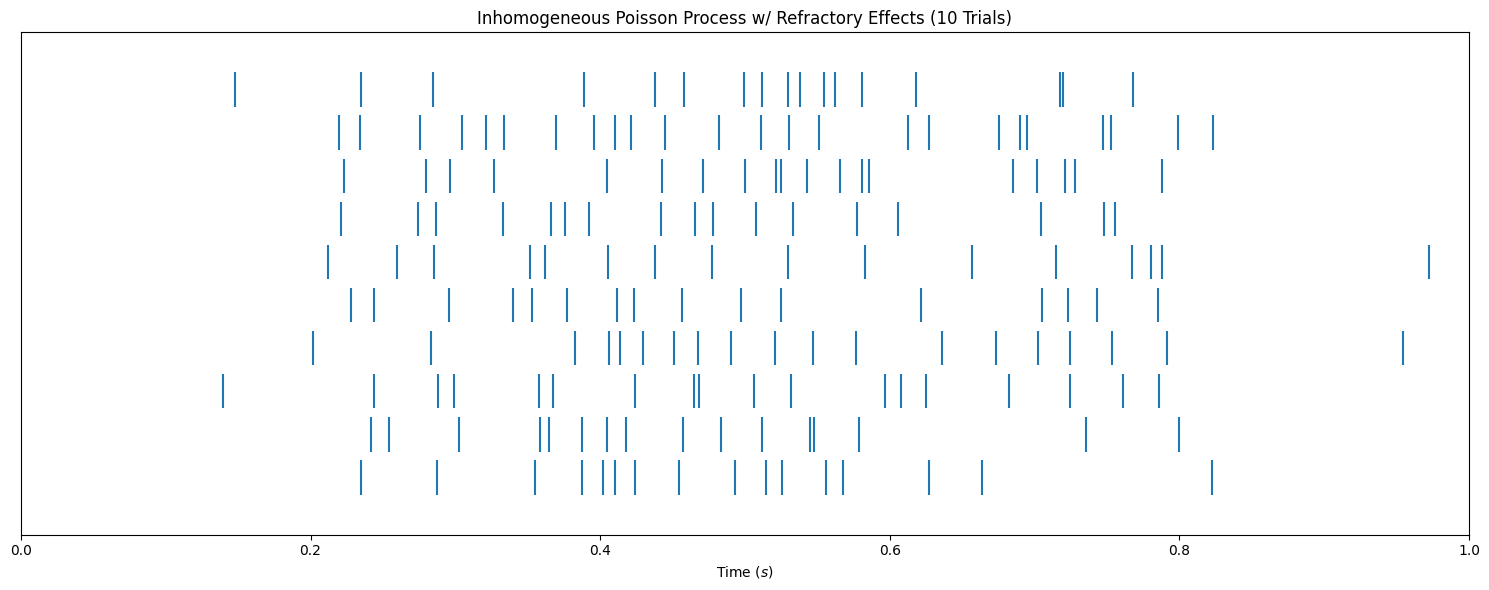

In [9]:
# Multiple Trials of Spike Generation
fig, ax = plt.subplots(1, 1, figsize=(15, 6))

trials = []
for i in range(10):
    trials.append(fast_spike_generator(r_t, T=T, dt=dt, abs_ref=abs_ref, rel_ref_mean=rel_ref_mean)["Inhomogeneous Spike Times w/ Refractory Effects"])
ax.set_xlim(0, T)
ax.set_title("Inhomogeneous Poisson Process w/ Refractory Effects (10 Trials)")
ax.set_xlabel("Time ($s$)")
ax.get_yaxis().set_visible(False)
ax.eventplot(trials, linelengths=0.8)
fig.tight_layout()

## Computations

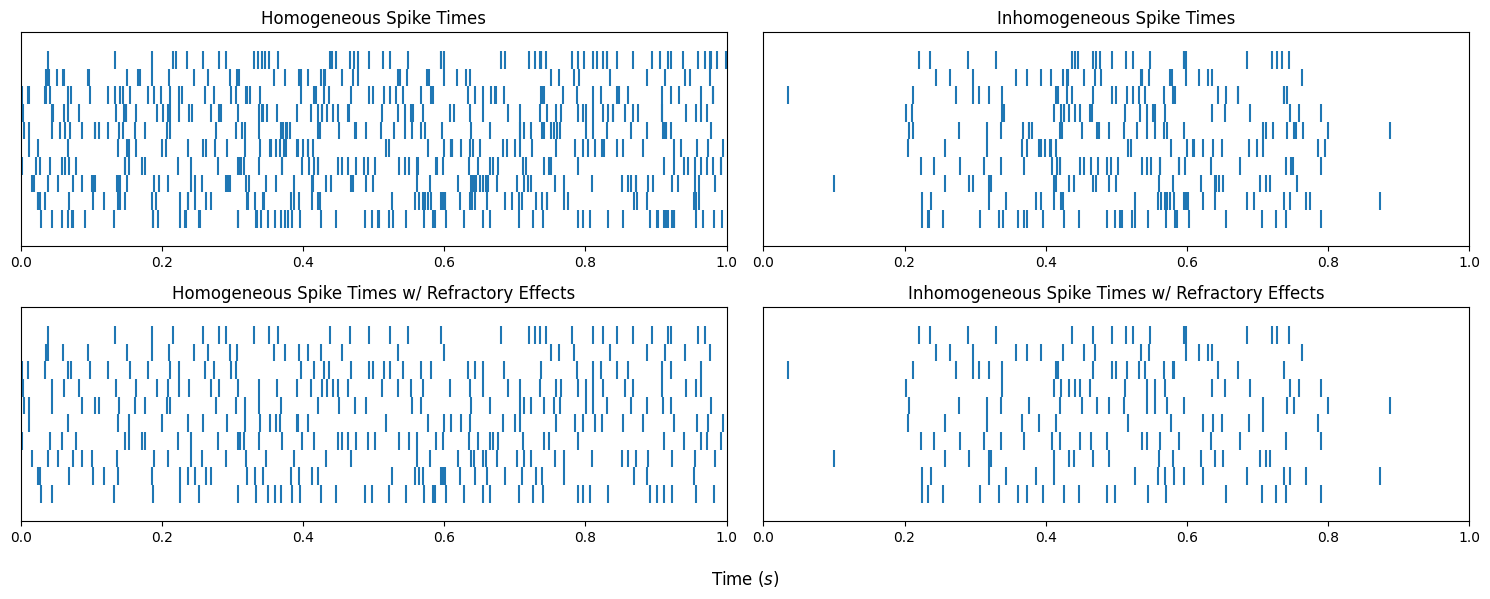

In [10]:
num_trials = 5000
trials_dict = {}

for key in fast_spike_generator(1):
    trials_dict[key] = []
    
for i in range(num_trials):
    spikes_dict = fast_spike_generator(r_t, T=T, dt=dt, abs_ref=abs_ref, rel_ref_mean=rel_ref_mean)
    for key, spike_times in spikes_dict.items():
        trials_dict[key].append(spike_times)
        
fig, axes = plt.subplots(2, 2, figsize=(15, 6), sharey=True)
for ax, (key, trials) in zip(axes.flatten('F'), trials_dict.items()):
    ax.eventplot(trials[:10])
    ax.set_title(key)
    ax.get_yaxis().set_visible(False)
    ax.set_xlim(0, 1)
fig.supxlabel("Time ($s$)")
fig.tight_layout()

### Fano Factor

> The ratio of these two quantities, $\sigma_n^2 / \langle n \rangle$, is called the Fano factor and takes the value 1 for a homogeneous Poisson process, independent of the time interval $T$. ({cite}`dayanTheoreticalNeuroscienceComputational2001`, p.44)

The two quantities mentioned are the variance and mean of the spike counts, respectively.

In [11]:
fano_statistics = []
for key, trials in trials_dict.items():
    num_spikes = [len(trial) for trial in trials]
    num_spikes_variance = np.var(num_spikes)
    num_spikes_trial_avg = np.mean(num_spikes)
    fano_factor = num_spikes_variance / num_spikes_trial_avg if num_spikes_trial_avg != 0 else np.nan

    fano_statistics.append([key, num_spikes_variance, num_spikes_trial_avg, fano_factor])

fano_statistics_df = pd.DataFrame(fano_statistics, columns=["Process", "Variance in Number of Spikes", "Avg Number of Spikes", "Fano Factor"])
fano_statistics_df

,Process,Variance in Number of Spikes,Avg Number of Spikes,Fano Factor
0,Homogeneous Spike Times,59.175276,59.9820,0.986551
1,Homogeneous Spike Times w/ Refractory Effects,17.972650,36.2824,0.495355
2,Inhomogeneous Spike Times,25.016264,24.3828,1.025980
3,Inhomogeneous Spike Times w/ Refractory Effects,9.781729,16.7056,0.585536


The Fano factor of the homogeneous poisson process is expectedly 1 but so is the Fano factor of the inhomogeneous poisson process; I suspect because the time-varying spike rate used for the inhomogeneous process is consistent through trials, the variance and mean of the spike count are still equal. The processes including refractory effects on the other hand are closer to 1/2. Since the Fano factor is the ratio of the variance to the mean of the number of spikes, a Fano factor of 1/2 indicates that the variance is lower than expected or the mean is higher than expected. Since refractory effects should only reduce the mean number of spikes, the former is more likely; I suspect that the refractory period is causing the spikes to be more evenly distributed, reducing the variance.

### Interspike Interval (ISI) Probability Distribution


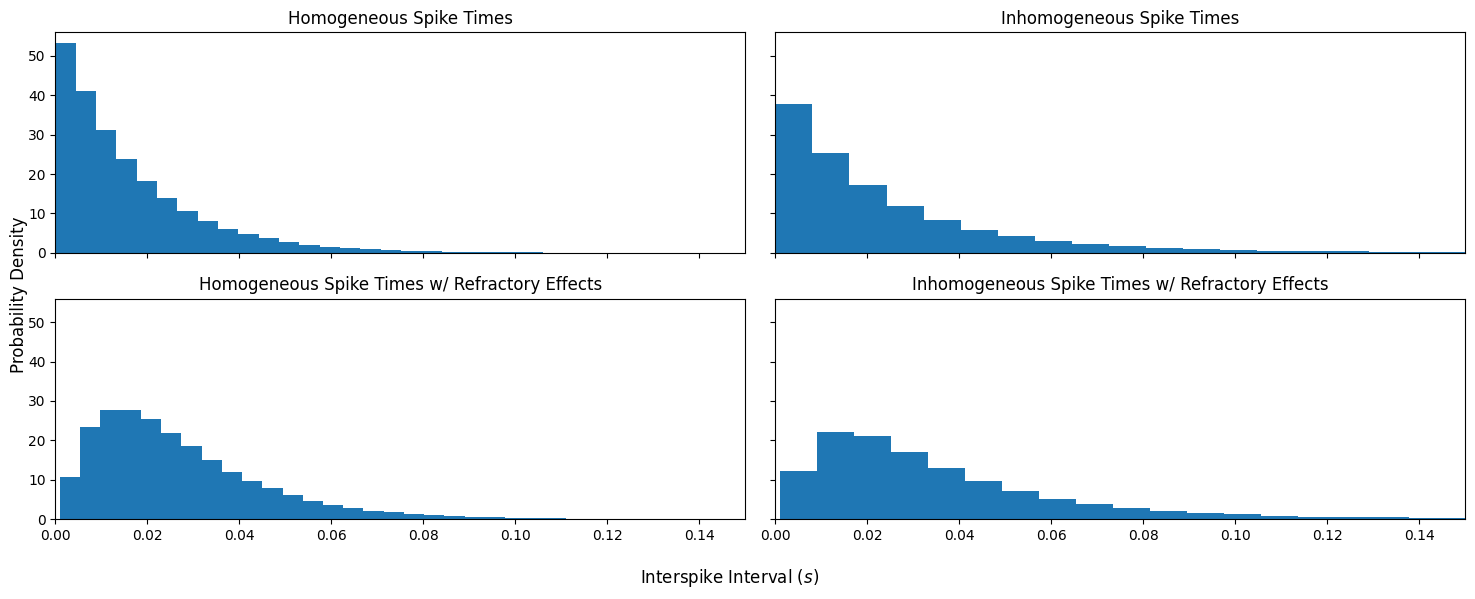

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 6), sharex=True, sharey=True)
interspike_intervals_dict = {}
for ax, (key, trials) in zip(axes.flatten('F'), trials_dict.items()):
    interspike_intervals_dict[key] = [np.diff(trial) for trial in trials] # An array of arrays where each array is the interspike intervals for a single trial
    interspike_intervals_dict[key] = np.concatenate(interspike_intervals_dict[key]) # Flatten to a single array
    ax.hist(interspike_intervals_dict[key], bins=50, density=True)
    ax.set_xlim(0, 0.15)
    ax.set_title(key)
fig.supylabel("Probability Density")
fig.supxlabel("Interspike Interval ($s$)")
fig.tight_layout()

The interspike interval probability distributions match the expected exponential distribution for the poisson processes and there is a clear impact of the refractory effects on the distribution. The refractory period prevents spikes from occurring too close together, resulting in the significant drop in the probabilities of short ISIs.

### Coefficient of Variation ($C_V$)

> The ratio of the standard deviation to the mean is called the coefficient of variation, $C_V = \frac{\sigma_{\tau}}{\langle \tau \rangle}$ and it takes the value 1 for a homogeneous Poisson process ({cite}`dayanTheoreticalNeuroscienceComputational2001`, p.44)


In [13]:
interspike_interval_statistics = []
for key, interspike_intervals in interspike_intervals_dict.items():
    interspike_interval_std = np.std(interspike_intervals)
    interspike_interval_trial_avg = np.mean(interspike_intervals)
    coeff_variation = interspike_interval_std / interspike_interval_trial_avg
    interspike_interval_statistics.append([key, interspike_interval_std, interspike_interval_trial_avg, coeff_variation])

interspike_interval_statistics_df = pd.DataFrame(interspike_interval_statistics, columns=["Process", "Interspike Interval Std", "Interspike Interval Avg", "Coefficient of Variation"])
interspike_interval_statistics_df

,Process,Interspike Interval Std,Interspike Interval Avg,Coefficient of Variation
0,Homogeneous Spike Times,0.016404,0.016401,1.000222
1,Homogeneous Spike Times w/ Refractory Effects,0.019160,0.027300,0.701839
2,Inhomogeneous Spike Times,0.029019,0.024929,1.164071
3,Inhomogeneous Spike Times w/ Refractory Effects,0.031959,0.036976,0.864305


As expected, the coefficient of variation is 1 for the homogeneous poisson process but is noticeably higher for the inhomogeneous poisson process. The increase in the coefficient of variation for the inhomogeneous process should also be expected as time-varying firing rate allows for more variation in the ISIs. The coefficient of variation for the processes including refractory effects are lower than 1 indicating the standard deviation is lower than expected or the mean is higher than expected. Since refactory periods remove spikes with a short interspike interval, the processes should increase the mean interspike interval. 

### Spike-Train Autocorrelation Function

The spike-train autocorrelation function is 
$$
Q_{\rho\rho}(\tau) = \frac{1}{T} \int_0^T dt \, \langle (\rho(t) - \langle r \rangle) (\rho(t+\tau) - \langle r \rangle) \rangle.
$$
where $\rho(t)$ is the neural response function and $\langle r \rangle$ is the trial average firing rate.

> The spike-train autocorrelation function is constructed from data in the form of a histogram by dividing time into bins. The value of the histogram for a bin labeled with a positive or negative integer $m$ is computed by determining the number of the times that any two spikes in the train are separated by a time interval lying between $(m - \frac{1}{2}) \Delta t$ and $(m + \frac{1}{2}) \Delta t$ with $\Delta t$ the bin size. This includes all pairings, even between a spike and itself. We call this number $N_m$. If the intervals between the $n^2$ spike pairs in the train were uniformly distributed over the range from $0$ to $T$, there would be $n^2 \Delta t / T$ intervals in each bin. This uniform term is removed from the autocorrelation histogram by subtracting $n^2 \Delta t / T$ from $N_m$ for all $m$. The spike-train autocorrelation histogram is then defined by dividing the resulting numbers by $T$, so the value of the histogram in bin $m$ is $H_m = \frac{N_m}{T} - \frac{n^2 \Delta t}{T^2}$ ... Because other bins have $H_m$ of order $\Delta t$, the large $m = 0$ term is often removed from histogram plots. ({cite}`dayanTheoreticalNeuroscienceComputational2001`, p.45)

To compute the autocorrelation function in this notebook, I create copies of the spike times shifted by the trial duration to practically create a periodic spike train. I then compute all time intervals between spikes in the original and shifted spike trains. Though the textbook does not mention the need for a periodic spike train, I found that the autocorrelation function would understandably create a triangular shape as the number of spikes separated by longer time intervals would be limited to the spikes at the beginning and end of the trial. 

The time intervals are then binned and can be adjusted as described in the textbook.

Number of spikes: 65
Autocorrelation at zero: 65


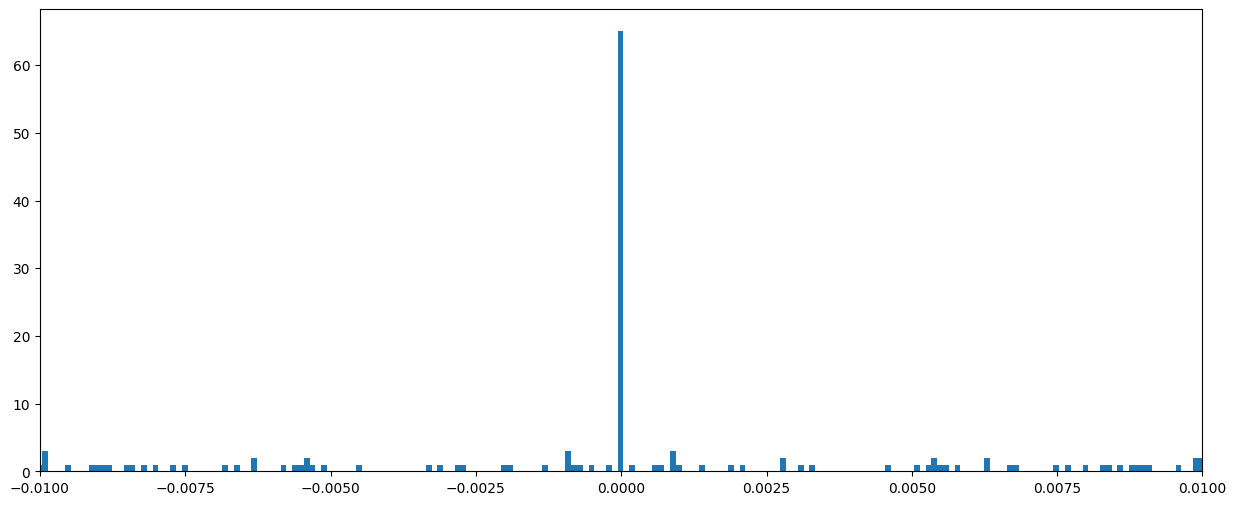

In [14]:
def spike_train_autocorrelation(
    spike_times: np.ndarray, 
    T: float = 1, 
    dt: float = 0.001,
    ax: plt.Axes = None
) -> np.ndarray:
    # Create left, and right copies for circular wrapping
    left = spike_times - T
    right = spike_times + T
    extended = np.concatenate((left, spike_times, right))

    # Compute an array of arrays where each array is the differences between a spike time and all other spike times including itself
    time_intervals = np.array([extended - x for x in spike_times]).flatten()
    # Cutoff to +- T
    valid_time_intervals = time_intervals[(time_intervals > -T) & (time_intervals < T)]
    
    num_bins = round(2 * T / dt) + 1 # plus 1 to center the 0 bin
    counts, bin_edges = np.histogram(valid_time_intervals, bins=num_bins)
    uniform_counts = round((len(spike_times) ** 2 * dt) / T)
    shifted_counts = counts - uniform_counts
    H_m = shifted_counts / T
    if ax is not None:
        ax.bar(bin_edges[:-1], H_m, width=np.diff(bin_edges), align="edge")
    return H_m, bin_edges

fig, ax = plt.subplots(1, 1, figsize=(15, 6))
spike_times = trials_dict["Homogeneous Spike Times"][0]

H_m, bin_edges = spike_train_autocorrelation(spike_times, T=T, dt=0.0001, ax=ax) # Use a small dt to estimate step size approaching 0 
ax.set_xlim(-0.01, 0.01)
print(f"Number of spikes: {len(spike_times)}")
zero_bin_index = np.searchsorted(bin_edges, 0, side='right') - 1
print(f"Autocorrelation at zero: {int(H_m[zero_bin_index])}")

> For small bin sizes, the $m = 0$ term in the histogram counts the average number of spikes, that is $N_m = \langle n \rangle$ and in the limit $\Delta t \to 0$, $H_0 = \frac{\langle n \rangle}{T}$ is the average firing rate $\langle r \rangle$. The spike-train autocorrelation function is defined as $H_m / \Delta t$ in the limit $\Delta t \to 0$, and it has the units of a firing rate squared. In this limit, the $m = 0$ bin becomes a $\delta$ function, $\frac{H_0}{\Delta t} \to \langle r \rangle \delta(\tau)$. ({cite}`dayanTheoreticalNeuroscienceComputational2001`, p.45)

As expected, when the bin size is set to $0.0001 \text{s} \approx 0$, the autocorrelation function is a $\delta$ function at $\tau = 0$ with a value equal to the average firing rate.

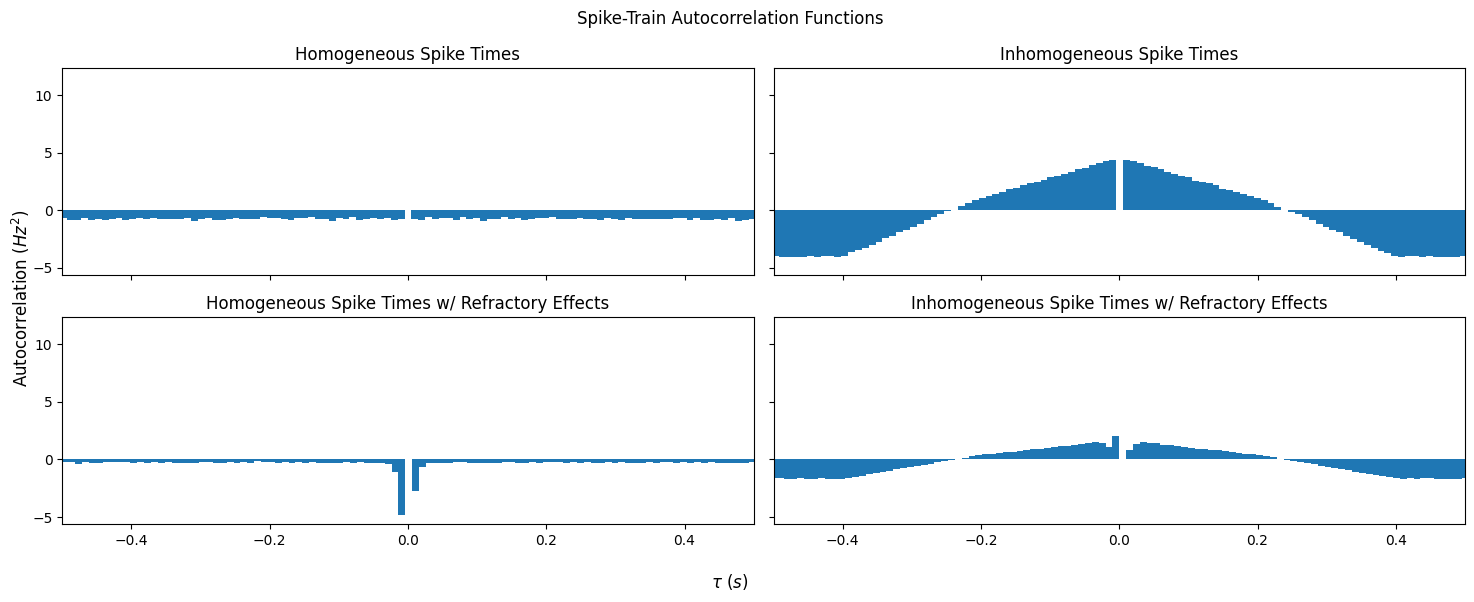

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(15, 6), sharex=True, sharey=True)
H_m_trials_dict = {}
H_m_avg_dict = {}
for ax, (key, trials) in zip(axes.flatten('F'), trials_dict.items()):
    H_m_trials_dict[key] = []
    for trial in trials:
        H_m, bin_edges = spike_train_autocorrelation(trial, T=T, dt=0.01)
        H_m_trials_dict[key].append(H_m)
        zero_bin_index = np.searchsorted(bin_edges, 0, side='right') - 1
        
    H_m_avg_dict[key] = np.mean(H_m_trials_dict[key], axis=0)
    # Set the zero bin to 0
    H_m_avg_dict[key][zero_bin_index] = 0
    ax.bar(bin_edges[:-1], H_m_avg_dict[key], width=np.diff(bin_edges), align="edge")
    ax.set_xlim(-0.5, 0.5)
    ax.set_title(key)

fig.suptitle("Spike-Train Autocorrelation Functions")
fig.supxlabel("$\\tau$ ($s$)")
fig.supylabel("Autocorrelation ($Hz^2$)")
fig.tight_layout()
        

When looking at the autocorrelation functions for the homogeneous and inhomogeneous poisson processes, the homogeneous process is expectedly uniformly distributed but the inhomogeneous process appears to have oscillations. The plot for the inhomogeneous process shows that there are more spikes separated by short time intervals than those separated by long time intervals. This is likely due to the centered time-varying firing rate, which causes the spikes to be huddled together in time.

The refractory effects expectedly reduce the number of spikes with a short time interval and result in the drop of the autocorrelation function near $\tau = 0$ similar to its effects on the ISI probability distribution.

**Other Considerations**

Due to the half-open bins in `np.histogram`, the autocorrelation function is not perfectly symmetric {cite}`NumpyhistogramNumPyV22`. I believe it is possible to improve the implementation of the spike-train autocorrelation function by using convolution or correlation functions, but I was unable to implement this at the time of writing. For the trial averaged spike-train autocorrelation function, I considered creating a concatenated spike train of all trials, and then computing the autocorrelation function by considering all pairs of spikes within the trial duration, but did not implement this because it would require a large amount of memory for a large number of trials and may not be what the function is meant to represent.

## Appendix

### A: Interspike Interval Auto-correlation

While trying to compute the spike-train autocorrelation function, I realized that I was computing the autocorrelation function of the interspike intervals instead. I am unsure how to interpret the results of this computation, or if it has any meaningful interpretation.

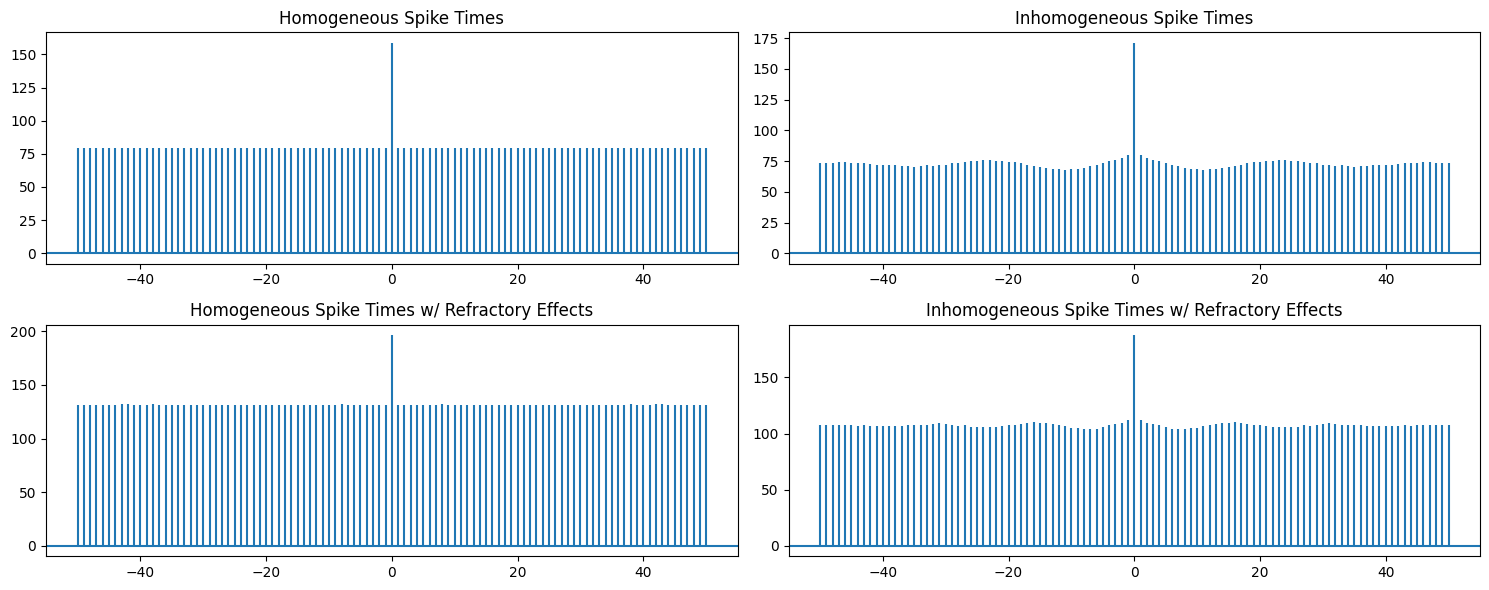

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(15, 6))
for ax, (key, interspike_intervals) in zip(axes.flatten('F'), interspike_intervals_dict.items()):
    lags, c, line, b = ax.acorr(interspike_intervals, maxlags=50, label=key, normed=False)
    ax.set_title(key)
fig.tight_layout()

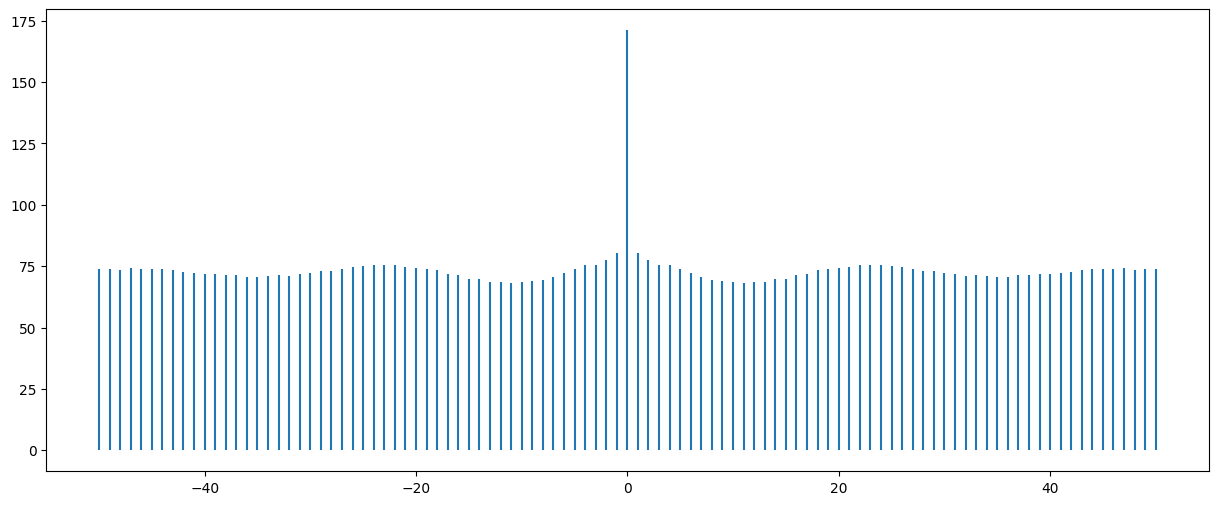

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
interspike_intervals = interspike_intervals_dict["Inhomogeneous Spike Times"]

maxlags = int(50)
Nx = len(interspike_intervals)

correls = np.correlate(interspike_intervals, interspike_intervals, mode="full")
if maxlags is None:
    maxlags = Nx - 1

lags = np.arange(-maxlags, maxlags + 1)
correls = correls[Nx - 1 - maxlags:Nx + maxlags]
ax.vlines(lags, [0], correls)

## References

```{bibliography}
```